In [26]:
# -------------------
# Imports and Setup
# -------------------

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from pathlib import Path
import matplotlib.pyplot as plt
import joblib

# Stonks Meme Aesthetic
plt.style.use("dark_background")
STONKS_GREEN = '#00ff9c'
STONKS_RED   = '#ff005c'
STONKS_BLUE  = '#00c3ff'
STONKS_PURP  = '#9d4edd'

FIG_DIR = Path("../figures")
FIG_DIR.mkdir(exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reload Raw Sequences
X = np.concatenate([
    np.load("../Neural Network for Volatility Forecasting/data/processed/X_train.npy"),
    np.load("../Neural Network for Volatility Forecasting/data/processed/X_val.npy")
])

y = np.concatenate([
    np.load("../Neural Network for Volatility Forecasting/data/processed/y_train.npy"),
    np.load("../Neural Network for Volatility Forecasting/data/processed/y_val.npy")
])

# Sequence Dates
sequence_dates = np.load("../data/processed/sequence_dates.npy", allow_pickle=True)

In [28]:
# ---------------------
# Rolling Window Setup
# ---------------------

train_size = 750
test_size = 252

splits = []

start = train_size

while start + test_size < len(X):
    X_train = X[:start]
    y_train = y[:start]
    
    X_test = X[start:start+test_size]
    y_test = y[start:start+test_size]
    
    splits.append((X_train, y_train, X_test, y_test))
    
    start += test_size

print("Total splits:", len(splits))

Total splits: 6


In [30]:
# --------------------------
# Volatility Optimized LSTM
# --------------------------

class VolatilityLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        
        # Use last timestep output
        out = out[:, -1, :]
        
        out = self.layer_norm(out)
        out = self.fc(out)
        
        return out.squeeze()


# Initialize the Model
input_dim = X_train.shape[2]

model = VolatilityLSTM(input_dim=input_dim).to(device)

criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

In [38]:
# ---------------------------
# Walk Forward Training Loop
# ---------------------------

walk_results = []

for i, (X_tr, y_tr, X_te, y_te) in enumerate(splits):
    
    print(f"\n=== Split {i+1} ===")
    
    model = VolatilityLSTM(input_dim=X.shape[2]).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    criterion = nn.HuberLoss()
    
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.tensor(X_tr, dtype=torch.float32),
            torch.tensor(y_tr, dtype=torch.float32)
        ),
        batch_size=64,
        shuffle=True
    )
    
    # Train small number of epochs (avoid heavy retraining)
    for epoch in range(15):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(torch.tensor(X_te, dtype=torch.float32).to(device)).cpu().numpy()
    
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    
    walk_results.append(rmse)
    print("Split RMSE:", rmse)




=== Split 1 ===
Split RMSE: 1.8636311689721172

=== Split 2 ===
Split RMSE: 0.626014253017749

=== Split 3 ===
Split RMSE: 0.4089472691336792

=== Split 4 ===
Split RMSE: 0.5756080219499479

=== Split 5 ===
Split RMSE: 0.2750930052615509

=== Split 6 ===
Split RMSE: 0.6427191460826878


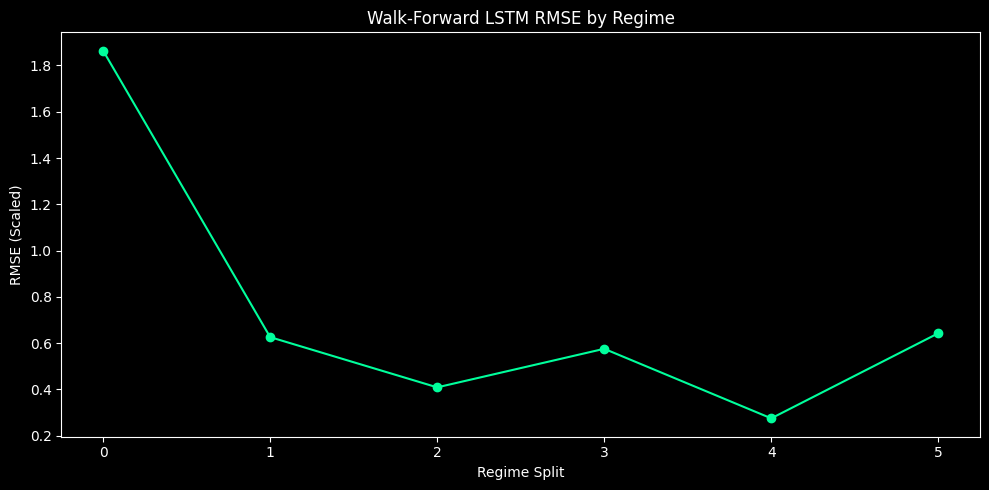

In [40]:
# Regime Change

plt.figure(figsize=(10,5))
plt.plot(walk_results, marker='o', color=STONKS_GREEN)
plt.title("Walk-Forward LSTM RMSE by Regime")
plt.xlabel("Regime Split")
plt.ylabel("RMSE (Scaled)")
plt.tight_layout()
plt.savefig(FIG_DIR / "walk_forward_rmse.png", dpi=150)
plt.show()

In [42]:
# Walk Results

np.mean(walk_results)
np.std(walk_results)

0.5223949131261912